* Mask radar data for hovmoller analysis (Cairns & Willis)
* Plots of overlayed satellite and radar data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import logging
import dask
from dask.distributed import Client
from dask import delayed
import functools
sys.path.append(os.path.join(r"/home/563/ac9768/GBR/scripts/Paper_figures")) 
from define_wind_regimes import wind_times

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
barra_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

In [4]:
client = Client(n_workers=28,threads_per_worker=1,memory_limit=None,silence_logs=logging.ERROR,dashboard_address='8787') 
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45217,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40659,Total threads: 1
Dashboard: /proxy/36659/status,Memory: 0 B
Nanny: tcp://127.0.0.1:40991,


In [5]:
# use barra-r2 wind directions to find defined wind regime times
ne_towns,se_towns,sw_towns,nw_towns = wind_times(barra_towns)
ne_cairns,se_cairns,sw_cairns,nw_cairns = wind_times(barra_cairns)
ne_willis,se_willis,sw_willis,nw_willis = wind_times(barra_willis)

# Read in through dask radar datasets

In [6]:
def path_to_radar_ds(radar_site_no: str):
    """Create list of file paths for the chosen radar ID.
    List selects JFMA data between 2012-01 and 2022-04

    Args:
        radar_site_no (str): String of radar ID number; cairns = "19", willis island = "41"

    Returns:
        list: List of file paths strings
    """
    list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/admin/level_2_decomissioned_fields/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

In [7]:
def radar_ds_subset(file_list: list):
    """Define and open a subset of the radar domain: the Hovmoller slice - taking the full longitudinal range and a latitudinal subset (-17S - -16.6S).
    1. Opens a single file to define the y values corresponding to the range (-17S, -16.6S)
    2. Define a preprocesser - apply quality control mask and select y values (x values are also selected to remove a few artefacts on the RHS of the Cairns domain)
    3. Return subset dataset

    Args:
        file_list (list): list of radar files to take subset

    Returns:
        xr.Dataset: Hovmoller slice rain rate data for the full time period
    """    
    with xr.open_dataset(file_list[0]) as ref_ds:
        lat_mean_along_x = ref_ds.latitude.mean(dim='x')
        lat_band = ((lat_mean_along_x > -17) & (lat_mean_along_x < -16.6)).compute()
        y_vals = ref_ds.y.where(lat_band, drop=True).values  # Get hovmoller slice y values

    def _preprocess(ds):
        # Apply quality control
        ds = ds.where(ds.isfile == 1)

        # Subset rainrate and Hovmoller slice
        rain = ds.rainrate.sel(y=y_vals, x=slice(-150000, 140000))
        
        return rain
    
    return xr.open_mfdataset(
        file_list,
        preprocess=_preprocess,
        parallel=True, 
        combine="by_coords")

In [8]:
def mask_radar_data(file_list: list, cairns: bool = None):
    """Mask subset rain rate dataset 
    1. Open subset data twice
    - mean_ds is used to find invalid points (where no measurements are taken)
    - ds is used to fill all nans as zeroes (where no rainfall is measured --> set to zero instead of nan)
    2. Apply masks 

    Args:
        file_list (list): List of file paths strings
        cairns (bool): Defaults to None. It true, beam blockage mask is also applied to the final dataset

    Returns:
        xr.Dataset: Xarray dataset of mean rain rate across the narrow latitude slice for each time step (with masks applied)
    """
    ds = radar_ds_subset(file_list)
    mean_ds = radar_ds_subset(file_list)

    # 1a. Identify regions where rainrate is *always* NaN (i.e., no measurements ever)
    valid_mask = mean_ds.rainrate.mean('time', skipna=True).notnull()
    if cairns:
        bb_mask = mean_ds.rainrate.mean('time') >= 1.2
        mask = valid_mask & bb_mask
    else:
        mask = valid_mask

    # 1b. Fill NaNs (individual missing values) with 0 --> raining+non-raining times/points
    rain = ds.rainrate.fillna(0)

    # 2. Apply the valid data mask (nan if always nan over time) and the beam blockage mask
    rain = rain.where(mask)
    return rain.mean('y')

In [9]:
def get_radar_under_wind_regimes(radar_ds: xr.Dataset,barra_regimes_ds: xr.Dataset):
    """Select masked subset of radar data for times under each wind regime. 
    1. Defined BARRA-R2 regimes are used to define each hour time-step
    - Radar data +30/-30 min from each hour defined as *regime is selected and appended
    2. Radar data under each regime is concatenated, groupby hour and taken mean over each hour
    3. Hourly timesteps adjusted for AEDT time

    Args:
        radar_ds (xr.Dataset): Subset and masked radar rainrate dataset (mean over latitude slice taken)
        barra_regimes_ds (xr.Dataset): BARRA-R2 regime dataset

    Returns:
        xr.DataArray: Xarray data array of mean rain rate (doubled in the 'hour' axis for plotting over 48 hours) 
    """
    # 1. use barra-r2 wind regimes to define times, take +30/-30min of the hour
    window_size = pd.Timedelta(minutes=30)
    select_data = []
    for time in barra_regimes_ds:
        window_start = time - window_size
        window_end = time + window_size
        data_in_window = radar_ds.sel(time=slice(window_start,window_end))
        select_data.append(data_in_window)

    results = xr.concat(select_data,dim='time').drop_duplicates(dim='time')
    grpby = results.groupby('time.hour').mean('time')
    roll = grpby.roll(hour=11,roll_coords=False)
    return xr.concat([roll, roll], dim='hour')

In [10]:
# return masked radar data
cairns_radar_files = path_to_radar_ds("19")
willis_radar_files = path_to_radar_ds("41")

cairns_ds = mask_radar_data(cairns_radar_files,cairns=True)
willis_ds = mask_radar_data(willis_radar_files)

In [11]:
# make dictionaries for regime and radar data
wind_regimes = {
    'cairns': {
        'ne': ne_cairns,
        'se': se_cairns,
        'sw': sw_cairns,
        'nw': nw_cairns,
    },
    # willis island regime times differ slightly to Cairns --> for comparison and analysis of propagation the Cairns regime time periods are used
    'willis': {
        'ne': ne_cairns,
        'se': se_cairns,
        'sw': sw_cairns,
        'nw': nw_cairns,
    },
}

radar_datasets = {
    'cairns': cairns_ds,
    'willis': willis_ds,
}

In [12]:
# create dictionary for resulting Hovmoller sliced radar data (masked and time adjusted) under BARRA-R2 regimes
results = {}

for domain, regime_dict in wind_regimes.items():
    results[domain] = {}
    for regime, regime_periods in regime_dict.items():
        results[domain][regime] = get_radar_under_wind_regimes(radar_datasets[domain],regime_periods)

# get satellite data

In [13]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/g/data/q90/ac9768/GBR/him8"
files = him8_files(directory)

In [14]:
ds_barra = xr.open_mfdataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa_winds_cairns.nc',engine="netcdf4")
ds_barra = ds_barra.sortby('time')
ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
winds = barra.wind_dir.compute()
def wind_times(winds):    
    ne = winds[(winds>=0)&(winds<=90)].time.values
    se = winds[(winds>90)&(winds<=180)].time.values
    sw = winds[(winds>180)&(winds<=270)].time.values
    nw = winds[(winds>270)&(winds<=360)].time.values
    return ne,se,sw,nw
ne,se,sw,nw = wind_times(winds)

In [15]:
def read_netcdf_him8(file_path,wind_times):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        barra_winds = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-17,-16.6)) 
        result_mean = barra_winds.groupby(barra_winds.time.dt.hour).mean(dim=["lat","time"]) 
    return result_mean 

In [16]:
ne_him_mean = read_netcdf_him8(files,ne)
se_him_mean = read_netcdf_him8(files,se)
sw_him_mean = read_netcdf_him8(files,sw)
nw_him_mean = read_netcdf_him8(files,nw)

In [17]:
ne_result_mean = ne_him_mean.compute()
se_result_mean = se_him_mean.compute()
sw_result_mean = sw_him_mean.compute()
nw_result_mean = nw_him_mean.compute()

In [18]:
ne_bt_mean_aedt = np.roll(ne_result_mean,shift=11,axis=0)
se_bt_mean_aedt = np.roll(se_result_mean,shift=11,axis=0)
sw_bt_mean_aedt = np.roll(sw_result_mean,shift=11,axis=0)
nw_bt_mean_aedt = np.roll(nw_result_mean,shift=11,axis=0)

In [19]:
bt_long = xr.open_dataset('/g/data/q90/ac9768/GBR/him8/2020_ch13BT_regridded_2kmres.nc', engine="h5netcdf", chunks="auto")
bt_lon = bt_long.lon.load().values

# Plot satellite and radar

In [20]:
# double all arrays to plot between 48 hours
def double_array(arr):
    return np.concatenate([arr, arr])

ne_double_him_mean = double_array(ne_bt_mean_aedt)
se_double_him_mean = double_array(se_bt_mean_aedt)
sw_double_him_mean = double_array(sw_bt_mean_aedt)
nw_double_him_mean = double_array(nw_bt_mean_aedt)

In [21]:
# load data for plotting
for domain in results:
    for regime in results[domain]:
        results[domain][regime] = results[domain][regime].load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.79 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 37.78 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/cli

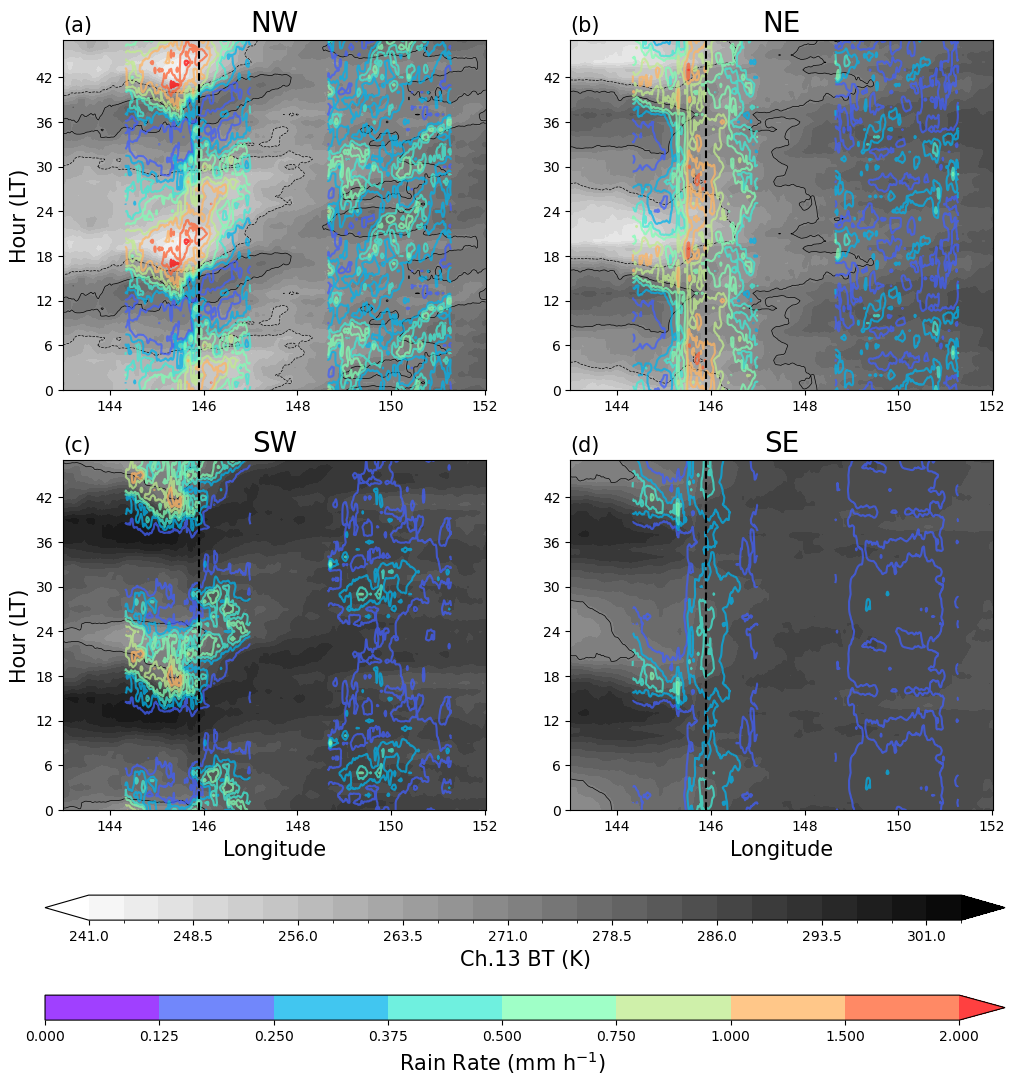

In [25]:
# setup figure
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2,2,figsize=(12,10))
fig.patch.set_facecolor('white')

# plot data
levels_h8 = np.arange(241,305,2.5)
levels_rr = np.arange(0,2,0.1)
levels_rr = [0,0.125,0.25,0.375,0.5,0.75,1,1.5,2]
alpha_rr = 0.75
# levels_rr = np.logspace(np.log10(0.01), np.log10(2.25), num=8)
cmap_h8 = matplotlib.cm.binary
cmap_rr = matplotlib.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(levels_h8, cmap_h8.N, extend='both')
norm_rr = matplotlib.colors.BoundaryNorm(levels_rr, cmap_rr.N,extend='max')  # , extend='max' if needed
# norm_rr = LogNorm(vmin=levels_rr[0], vmax=levels_rr[-1])

# x values
bt_long = xr.open_dataset('/g/data/q90/ac9768/GBR/him8/2020_ch13BT_regridded_2kmres.nc', engine="h5netcdf", chunks="auto")
bt_lon = bt_long.lon.values
x_cairns = xr.open_dataset(cairns_radar_files[0]).longitude.sel(x=slice(-150000,140000)).mean('y').values
x_willis = xr.open_dataset(willis_radar_files[0]).longitude.sel(x=slice(-150000,140000)).mean('y').values

# y values
time = np.arange(0,48,1)

# z values
ax[0,1].contourf(bt_lon,time,ne_double_him_mean,levels=levels_h8,cmap=cmap_h8,alpha=1)
ax[0,1].contour(bt_lon,time,ne_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,1].contour(bt_lon,time,ne_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')
ax[0,1].contour(x_cairns,time,results['cairns']['ne'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)
ax[0,1].contour(x_willis,time,results['willis']['ne'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)

ax[1,1].contourf(bt_lon,time,se_double_him_mean,levels=levels_h8,cmap=cmap_h8,alpha=1)
ax[1,1].contour(bt_lon,time,se_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[1,1].contour(x_cairns,time,results['cairns']['se'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)
ax[1,1].contour(x_willis,time,results['willis']['se'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)

ax[1,0].contourf(bt_lon,time,sw_double_him_mean,levels=levels_h8,cmap=cmap_h8,alpha=1)
ax[1,0].contour(bt_lon,time,sw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[1,0].contour(x_cairns,time,results['cairns']['sw'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)
ax[1,0].contour(x_willis,time,results['willis']['sw'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)

ax[0,0].contourf(bt_lon,time,nw_double_him_mean,levels=levels_h8,cmap=cmap_h8,alpha=1)
ax[0,0].contour(bt_lon,time,nw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,0].contour(bt_lon,time,nw_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')
ax[0,0].contour(x_cairns,time,results['cairns']['nw'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)
ax[0,0].contour(x_willis,time,results['willis']['nw'],levels=levels_rr,cmap=cmap_rr,alpha=alpha_rr,norm=norm_rr)

# colorbars
cax = fig.add_axes([0.11, 0, 0.8, 0.025])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_h8)
sm.set_array([])  # Empty array since data is already in the norm
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(label='Ch.13 BT (K)', fontsize=15)

dax = fig.add_axes([0.11, -0.1, 0.8, 0.025])  # [left, bottom, width, height]
norm_rr = matplotlib.colors.BoundaryNorm(levels_rr, cmap_rr.N,extend='max')  # , extend='max' if needed
sm_rr = plt.cm.ScalarMappable(norm=norm_rr, cmap=cmap_rr)
sm_rr.set_array([])
cbar_rr = fig.colorbar(sm_rr, cax=dax, orientation='horizontal',alpha=alpha_rr)
cbar_rr.set_label(r'Rain Rate (mm h$^{-1}$)', fontsize=15)

# other plot details
ax[1,1].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_ylabel("Hour (LT)",fontsize=15)
ax[0,0].set_ylabel("Hour (LT)",fontsize=15)

ax[0,1].set_title("NE",fontsize=20)
ax[0, 1].set_title("(b)", loc="left", fontsize=15)

ax[1,1].set_title("SE",fontsize=20)
ax[1, 1].set_title("(d)", loc="left", fontsize=15)

ax[1,0].set_title("SW",fontsize=20)
ax[1, 0].set_title("(c)", loc="left", fontsize=15)

ax[0,0].set_title("NW",fontsize=20)
ax[0, 0].set_title("(a)", loc="left", fontsize=15)

for ax in ax.flat:
    ax.set_yticks(np.arange(0,48,6))
    ax.axvline(145.9,color='black',alpha=1,linestyle='--')
    # ax.grid(linestyle='--',alpha=0.5)
fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f07.png',bbox_inches='tight',dpi=300)

In [47]:
# open topography dataset
ds_full = xr.open_dataset('/home/563/ac9768/GBR/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

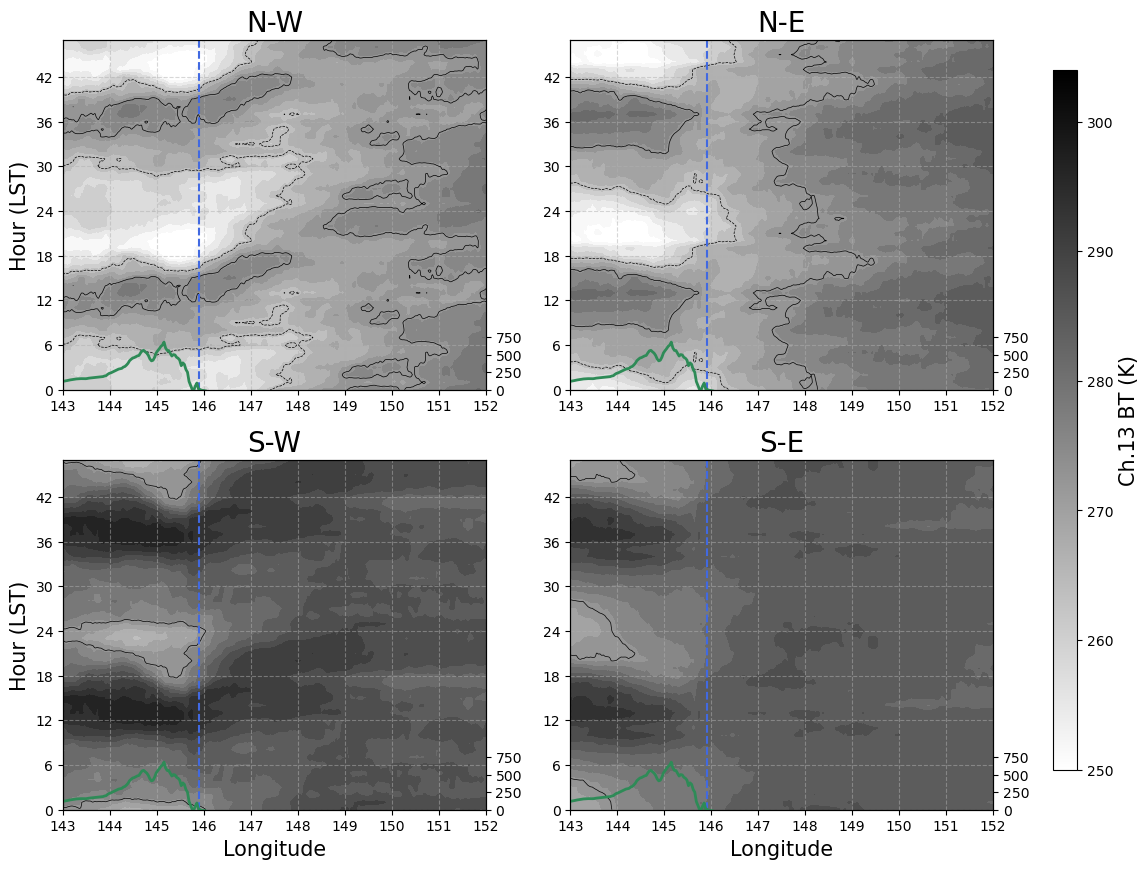

In [52]:
# topo
fig, ax = plt.subplots(2,2,figsize=(12,10))
fig.patch.set_facecolor('white')
levels=np.arange(250,305,3)
ax[0,1].contourf(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[0,1].contour(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,1].contour(bt_lon,np.arange(0,48,1),ne_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')
ax[1,1].contourf(bt_lon,np.arange(0,48,1),se_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[1,1].contour(bt_lon,np.arange(0,48,1),se_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[1,0].contourf(bt_lon,np.arange(0,48,1),sw_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[1,0].contour(bt_lon,np.arange(0,48,1),sw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,0].contourf(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=levels,cmap="binary",alpha=1)
ax[0,0].contour(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=[273],colors="black",alpha=1,linewidths=0.5)
ax[0,0].contour(bt_lon,np.arange(0,48,1),nw_double_him_mean,levels=[263],colors="black",alpha=1,linewidths=0.5,linestyles='--')

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# # Create a colorbar using the ScalarMappable from one of the subplots
sm = plt.cm.ScalarMappable(cmap="binary")
sm.set_array(levels)  # You need to set an array for the ScalarMappable
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(label='Ch.13 BT (K)',fontsize=15)

# plot topography
# make twin axis for topography overlay
ax1 = ax[0,0].twinx()
ax1.set_ylim(0,5000)
ax1.set_yticks(np.arange(0,1000,250))
ax1.set_xlim(143,152)
ax2 = ax[0,1].twinx()
ax2.set_ylim(0,5000)
ax2.set_yticks(np.arange(0,1000,250))
ax2.set_xlim(143,152)
ax3 = ax[1,0].twinx()
ax3.set_ylim(0,5000)
ax3.set_yticks(np.arange(0,1000,250))
ax3.set_xlim(143,152)
ax4 = ax[1,1].twinx()
ax4.set_ylim(0,5000)
ax4.set_yticks(np.arange(0,1000,250))
ax4.set_xlim(143,152)
long=ds_bath.sel(y=-16.8,method='nearest').drop_vars('z')
ax1.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
# ax1.plot(long.x,ds_bath['z'].sel(y=-16.8,method='nearest'),color='seagreen',linewidth=2)
ax2.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
ax3.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)
ax4.plot(long.x,ds_bath['z'].sel(y=slice(-16.993225,-16.633728)).mean(dim='y'),color='seagreen',linewidth=2)

ax[1,1].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_xlabel("Longitude",fontsize=15)
ax[1,0].set_ylabel("Hour (LST)",fontsize=15)
ax[0,0].set_ylabel("Hour (LST)",fontsize=15)
ax[0,0].set_yticks(np.arange(0,48,6))
ax[0,1].set_yticks(np.arange(0,48,6))
ax[1,0].set_yticks(np.arange(0,48,6))
ax[1,1].set_yticks(np.arange(0,48,6))
ax[0,1].set_title("N-E",fontsize=20)
ax[1,1].set_title("S-E",fontsize=20)
ax[1,0].set_title("S-W",fontsize=20)
ax[0,0].set_title("N-W",fontsize=20)
ax[0,1].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[1,1].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[1,0].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[0,0].axvline(145.9,color='royalblue',alpha=1,linestyle='--')
ax[0,1].grid(linestyle='--',alpha=0.5)
ax[1,1].grid(linestyle='--',alpha=0.5)
ax[1,0].grid(linestyle='--',alpha=0.5)
ax[0,0].grid(linestyle='--',alpha=0.5)

In [ ]:
len(wind_times)/24

In [ ]:
len(merged_500.time)/24

In [ ]:
def plot_barra_variables(barra_variable,level,cmap,scm,ne,se,sw,nw,cbar_label,title):
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    fig.patch.set_facecolor('white')
    levels = level
    cf_ne = ax[0,1].contourf(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,cmap=cmap)
    cf_se = ax[1,1].contourf(barra_variable.lon,np.arange(0,48,1),se,levels=levels,cmap=cmap)
    cf_sw = ax[1,0].contourf(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,cmap=cmap)
    cf_nw = ax[0,0].contourf(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,cmap=cmap)
    ax[0,1].contour(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,colors="black",linewidths=1)
    ax[1,1].contour(barra_variable.lon,np.arange(0,48,1),se,levels=levels,colors="black",linewidths=1)
    ax[1,0].contour(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,colors="black",linewidths=1)
    ax[0,0].contour(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,colors="black",linewidths=1)
    # for colorbar plotting
    cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    # # Create a colorbar using the ScalarMappable from one of the subplots
    sm = plt.cm.ScalarMappable(cmap=scm)
    sm.set_array(levels)  # You need to set an array for the ScalarMappable
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(cbar_label,fontsize=10)
    yticks = np.arange(0,48,6)
    ax[0,1].set_yticks(yticks)
    ax[1,1].set_yticks(yticks)
    ax[1,0].set_yticks(yticks)
    ax[0,0].set_yticks(yticks)
    
    ax[0,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_xlabel('Longitude')
    ax[1,1].set_xlabel('Longitude')
    
    ax[0,1].set_title("NE")
    ax[1,1].set_title("SE")
    ax[1,0].set_title("SW")
    ax[0,0].set_title("NW")
    fig.suptitle(title+' Regime Composites')
    return
plot_barra_variables(barra_cairns_rad,np.arange(0,1000,50),"plasma",plt.cm.plasma,sfc_ne,sfc_se,sfc_sw,sfc_nw,'W M-2','Cairns Surface Net SW Flux')